# Introduction of Deep Learning for Computer Vision 
### Computer Vision and Machine Learning Research Group, Shenzhen University, 2019 Dec.

Network Structure: LeNet  
Dataset: cifar-10 or ImageNet

C. Szegedy et al., "Going deeper with convolutions," 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, 2015, pp. 1-9.
[Download Link](
https://arxiv.org/pdf/1409.4842v1.pdf)  

Code is mostly based on:  
https://www.cnblogs.com/zhengbiqing/p/10425811.html contact：zhengbiqing 460356155@qq.com  

Dataset can be downloaded from:
http://www.cs.toronto.edu/~kriz/cifar.html  

In [1]:
import torch as t
import torchvision as tv
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.backends.cudnn as cudnn

import datetime
import argparse


# 样本读取线程数
WORKERS = 4

# 网络参赛保存文件名
PARAS_FN = 'cifar_lenet_params.pkl'

# minist数据存放位置
ROOT = '/home/zbq/PycharmProjects/cifar'
ROOT = '/home/szu-admin/local/data/cifar-10-100/cifar.10.py'

# 目标函数
loss_func = nn.CrossEntropyLoss()

# 最优结果
best_acc = 0

In [2]:
'''
创建VGG块
参数分别为输入通道数，输出通道数，卷积层个数，是否做最大池化
'''
def make_vgg_block(in_channel, out_channel, convs, pool=True):
    net = []

    # 不改变图片尺寸卷积
    net.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))
    net.append(nn.BatchNorm2d(out_channel))
    net.append(nn.ReLU(inplace=True))

    for i in range(convs - 1):
        # 不改变图片尺寸卷积
        net.append(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1))
        net.append(nn.BatchNorm2d(out_channel))
        net.append(nn.ReLU(inplace=True))

    if pool:
        # 2*2最大池化，图片变为w/2 * h/2
        net.append(nn.MaxPool2d(2))

    return nn.Sequential(*net)


# 定义网络模型
class VGG19Net(nn.Module):
    def __init__(self):
        super(VGG19Net, self).__init__()

        net = []

        # 输入32*32，输出16*16
        net.append(make_vgg_block(3, 64, 2))

        # 输出8*8
        net.append(make_vgg_block(64, 128, 2))

        # 输出4*4
        net.append(make_vgg_block(128, 256, 4))

        # 输出2*2
        net.append(make_vgg_block(256, 512, 4))

        # 无池化层，输出保持2*2
        net.append(make_vgg_block(512, 512, 4, False))

        self.cnn = nn.Sequential(*net)

        self.fc = nn.Sequential(
            # 512个feature，每个feature 2*2
            nn.Linear(512*2*2, 256),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.ReLU(),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.cnn(x)

        # x.size()[0]: batch size
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x




'''
训练并测试网络
net：网络模型
train_data_load：训练数据集
optimizer：优化器
epoch：第几次训练迭代
log_interval：训练过程中损失函数值和准确率的打印频率
'''
def net_train(net, train_data_load, optimizer, epoch, log_interval):
    net.train()

    begin = datetime.datetime.now()

    # 样本总数
    total = len(train_data_load.dataset)

    # 样本批次训练的损失函数值的和
    train_loss = 0

    # 识别正确的样本数
    ok = 0

    for i, data in enumerate(train_data_load, 0):
        img, label = data
        img, label = img.cuda(), label.cuda()

        optimizer.zero_grad()

        outs = net(img)
        loss = loss_func(outs, label)
        loss.backward()
        optimizer.step()

        # 累加损失值和训练样本数
        train_loss += loss.item()
        # total += label.size(0)

        _, predicted = t.max(outs.data, 1)
        # 累加识别正确的样本数
        ok += (predicted == label).sum()

        if (i + 1) % log_interval == 0:
            # 训练结果输出

            # 损失函数均值
            loss_mean = train_loss / (i + 1)

            # 已训练的样本数
            traind_total = (i + 1) * len(label)

            # 准确度
            acc = 100. * ok / traind_total

            # 一个迭代的进度百分比
            progress = 100. * traind_total / total

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  Acc: {:.6f}'.format(
                epoch, traind_total, total, progress, loss_mean, acc))

    end = datetime.datetime.now()
    print('one epoch spend: ', end - begin)


'''
用测试集检查准确率
'''
def net_test(net, test_data_load, epoch):
    net.eval()

    ok = 0

    for i, data in enumerate(test_data_load):
        img, label = data
        img, label = img.cuda(), label.cuda()

        outs = net(img)
        _, pre = t.max(outs.data, 1)
        ok += (pre == label).sum()

    acc = ok.item() * 100. / (len(test_data_load.dataset))
    print('EPOCH:{}, ACC:{}\n'.format(epoch, acc))

    global best_acc
    if acc > best_acc:
        best_acc = acc


'''
显示数据集中一个图片
'''
def img_show(dataset, index):
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    show = ToPILImage()

    data, label = dataset[index]
    print('img is a ', classes[label])
    show((data + 1) / 2).resize((100, 100)).show()

In [3]:
#parser = argparse.ArgumentParser(description='PyTorch CIFA10 LeNet Example')

In [4]:
# 训练超参数设置，可通过命令行设置
bs = 64            # batch-size
testbs = 1000      # test-batch-size
ep = 20            # epochs 
trainlr = 0.01     # learning rate (default: 0.01)
mm = 0.9           # SGD momentum (default: 0.9)
logint = 100       # logging-interval
notrain = False    # If train the Model
savemodel = False  # For Saving the current Model

In [5]:
# 图像数值转换，ToTensor源码注释
"""
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
"""
# 归一化把[0.0, 1.0]变换为[-1,1], ([0, 1] - 0.5) / 0.5 = [-1, 1]
transform = tv.transforms.Compose([
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# 定义数据集
#train_data = tv.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=transform)
train_data = tv.datasets.CIFAR10(root=ROOT, train=True, download=False, transform=transform)
test_data = tv.datasets.CIFAR10(root=ROOT, train=False, download=False, transform=transform)

train_load = t.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=WORKERS)
test_load = t.utils.data.DataLoader(test_data, batch_size=testbs, shuffle=False, num_workers=WORKERS)

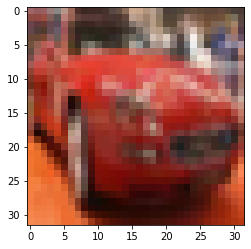

In [6]:
# 看一下数据中的等待分类的图片
import torch.utils.data
from PIL import Image
import sys
#im = Image.open(train_data.data[5][0])
im = Image.fromarray(train_data.data[5][:])
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im)

In [7]:
train_data[5][:]

(tensor([[[ 0.2471,  0.1765,  0.2000,  ..., -0.2863, -0.4196, -0.4039],
          [ 0.1137,  0.1451,  0.2157,  ..., -0.0039, -0.0431, -0.3255],
          [-0.1451, -0.2235, -0.1765,  ...,  0.0745,  0.2784, -0.2706],
          ...,
          [ 0.9137,  0.8824,  0.8902,  ...,  0.2235,  0.4039,  0.5686],
          [ 0.9294,  0.9059,  0.9059,  ...,  0.2706,  0.3961,  0.5059],
          [ 0.9294,  0.9059,  0.9137,  ...,  0.3020,  0.3569,  0.4275]],
 
         [[-0.2000, -0.2863, -0.2549,  ..., -0.4431, -0.5059, -0.5451],
          [-0.4118, -0.4353, -0.4039,  ..., -0.1765, -0.1294, -0.4588],
          [-0.4745, -0.5451, -0.5373,  ..., -0.1216,  0.0353, -0.4353],
          ...,
          [ 0.0118, -0.0353, -0.0431,  ..., -0.6706, -0.5373, -0.4275],
          [ 0.0431,  0.0039, -0.0039,  ..., -0.6549, -0.5608, -0.4902],
          [ 0.0902,  0.0431,  0.0353,  ..., -0.6314, -0.6000, -0.5529]],
 
         [[-0.2078, -0.2549, -0.2392,  ..., -0.5608, -0.5686, -0.5686],
          [-0.4667, -0.4824,

In [8]:
# define LeNet
net = VGG19Net().cuda()
# print network structure
print(net)

VGG19Net(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [9]:
# 如果不训练，直接加载保存的网络参数进行测试集验证
if notrain:
    net.load_state_dict(t.load(PARAS_FN))
    net_test(net, test_load, 0)

else:
    optimizer = optim.SGD(net.parameters(), lr=trainlr, momentum=mm)

    start_time = datetime.datetime.now()

    for epoch in range(1, ep + 1):
        net_train(net, train_load, optimizer, epoch, logint)

        # 每个epoch结束后用测试集检查识别准确度
        net_test(net, test_load, epoch)

        end_time = datetime.datetime.now()

    global best_acc
    #print('CIFAR10 pytorch LeNet Train: EPOCH:{}, BATCH_SZ:{}, LR:{}, ACC:{}'.format(args.epochs, args.batch_size, lr, best_acc))
    print('CIFAR10 pytorch VGG Train: EPOCH:{}, BATCH_SZ:{}, LR:{}, ACC:{}'.format(ep, bs, trainlr, best_acc))
    print('train spend time: ', end_time - start_time)

    if savemodel:
        t.save(net.state_dict(), PARAS_FN)

Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.957954  Acc: 23.000000
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.822127  Acc: 29.000000
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.736716  Acc: 32.000000
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.668329  Acc: 35.000000
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.614789  Acc: 38.000000
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.560977  Acc: 40.000000
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.515182  Acc: 42.000000
one epoch spend:  0:00:52.329624
EPOCH:1, ACC:58.17

Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.113011  Acc: 60.000000
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.088249  Acc: 61.000000
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.056068  Acc: 62.000000
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.041656  Acc: 63.000000
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.025482  Acc: 64.000000
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.010425  Acc: 64.000000
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.993115  Acc: 65.000000
one epoch spend:  0:00:51

one epoch spend:  0:00:51.352622
EPOCH:16, ACC:84.95

Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.070733  Acc: 97.000000
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.064635  Acc: 97.000000
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.070918  Acc: 97.000000
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.074762  Acc: 97.000000
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.076548  Acc: 97.000000
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.075248  Acc: 97.000000
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.074238  Acc: 97.000000
one epoch spend:  0:00:51.335060
EPOCH:17, ACC:84.91

Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.053149  Acc: 98.000000
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.054495  Acc: 97.000000
Train Epoch: 18 [19200/50000 (38%)]	Loss: 0.051650  Acc: 98.000000
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.057129  Acc: 98.000000
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.061798  Acc: 97.000000
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.061933  Acc: 97.000000
Train Epoch: 18 [44800/